In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries Used



In [ ]:
import os
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10
from PIL import Image, UnidentifiedImageError
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Dataset Loading And Visualization

In [ ]:
def load_images_from_folder(folder):
    images = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    for filename in os.listdir(folder):
        if not any(filename.lower().endswith(ext) for ext in valid_extensions):
            print(f"Skipped non-image file: {filename}")
            continue
        img_path = os.path.join(folder, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                img = transform(img)
                images.append(img)
        except UnidentifiedImageError:
            print(f"Skipped invalid image file: {img_path}")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    return images

cancer_dir = '/content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER'
non_cancer_dir = '/content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER'

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

cancer_images = load_images_from_folder(cancer_dir)
non_cancer_images = load_images_from_folder(non_cancer_dir)

selected_images = cancer_images[:250] + non_cancer_images[:250]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/101.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/273.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/328.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/200.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/317.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/407.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/485.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/455.jpeg
Skipped invalid image file: /content/drive/MyDrive/Oral cancer Dataset 2.0/OC Dataset kaggle new

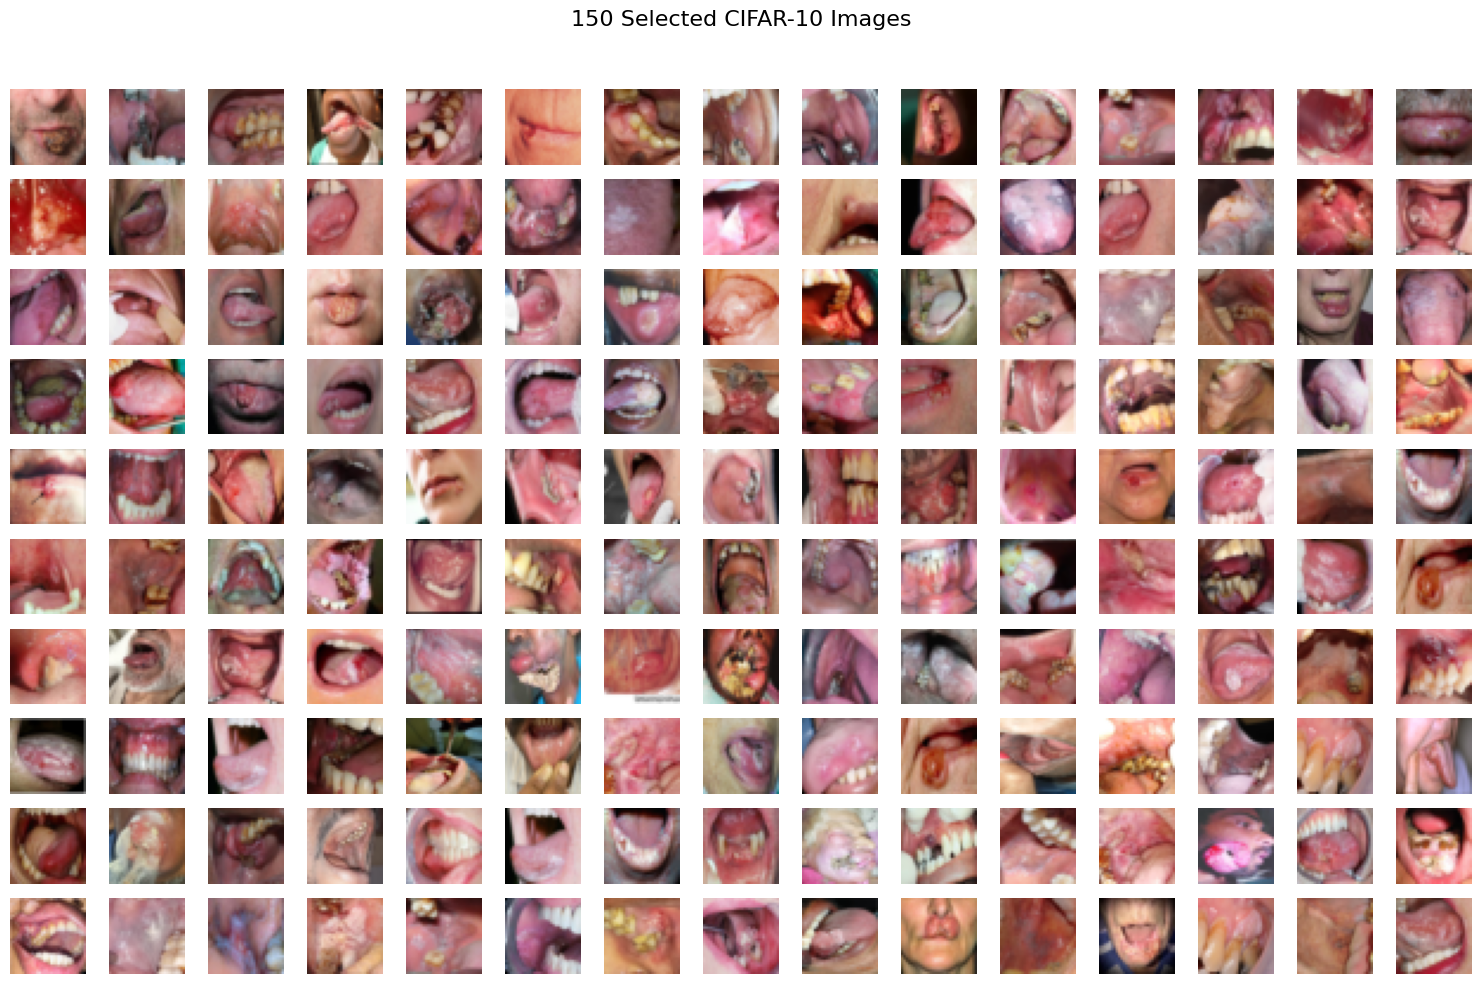

In [ ]:
# Plot the selected images
fig, axes = plt.subplots(10, 15, figsize=(15, 10))
fig.suptitle("150 Selected CIFAR-10 Images", fontsize=16)

for i in range(10):
    for j in range(15):
        img = selected_images[i * 15 + j].permute(1, 2, 0).numpy()

        axes[i, j].imshow(img)
        axes[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Implementation for Image Denoising and Compression Using SVD

In [ ]:
# add Gaussian noise
def add_gaussian_noise(image, mean=0.0, std=0.05):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return noisy_image

In [ ]:
# Function to represent images as matrices
def represent_images_as_matrices(images):
    matrices = []
    for image in images:
        noisy_image = add_gaussian_noise(image)
        image_matrix = (noisy_image.permute(1, 2, 0).numpy() * 255).astype(int)
        matrices.append(image_matrix)

    return matrices

In [ ]:
# apply SVD to image matrix
def apply_svd_to_images(matrices):
    svd_results = []
    for matrix in matrices:
        R = matrix[:, :, 0].astype(np.float32)
        G = matrix[:, :, 1].astype(np.float32)
        B = matrix[:, :, 2].astype(np.float32)

        U_R, S_R, Vt_R = np.linalg.svd(R, full_matrices=False)
        U_G, S_G, Vt_G = np.linalg.svd(G, full_matrices=False)
        U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

        svd_results.append(((U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B)))

    return svd_results

In [ ]:
def truncate_to_top_k_singular_values(svd_results, k=50):
    truncated_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.zeros_like(S_R)
        S_R_truncated[:k] = S_R[:k]

        S_G_truncated = np.zeros_like(S_G)
        S_G_truncated[:k] = S_G[:k]

        S_B_truncated = np.zeros_like(S_B)
        S_B_truncated[:k] = S_B[:k]

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        truncated_images.append(reconstructed_image)

    return truncated_images

In [ ]:
# Function to truncate small singular values
def truncate_small_singular_values(svd_results, threshold=50):
    truncated_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.where(S_R < threshold, 0, S_R)
        S_G_truncated = np.where(S_G < threshold, 0, S_G)
        S_B_truncated = np.where(S_B < threshold, 0, S_B)

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        truncated_images.append(reconstructed_image)

    return truncated_images

In [ ]:
# Function to reconstruct the denoised image
def reconstruct_denoised_image(svd_results):
    denoised_images = []
    for (U_R, S_R, Vt_R), (U_G, S_G, Vt_G), (U_B, S_B, Vt_B) in svd_results:

        S_R_truncated = np.where(S_R < 50, 0, S_R)
        S_G_truncated = np.where(S_G < 50, 0, S_G)
        S_B_truncated = np.where(S_B < 50, 0, S_B)

        reconstructed_R = np.dot(U_R, np.dot(np.diag(S_R_truncated), Vt_R))
        reconstructed_G = np.dot(U_G, np.dot(np.diag(S_G_truncated), Vt_G))
        reconstructed_B = np.dot(U_B, np.dot(np.diag(S_B_truncated), Vt_B))

        reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1)

        reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
        denoised_images.append(reconstructed_image)

    return denoised_images

# Visualization of Image Denoising Using SVD

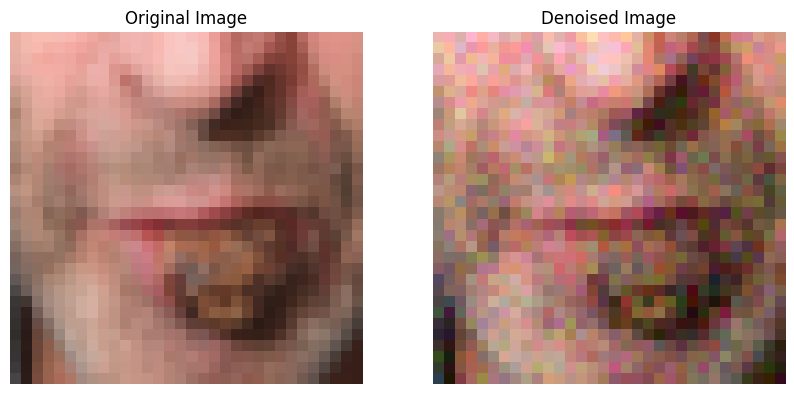

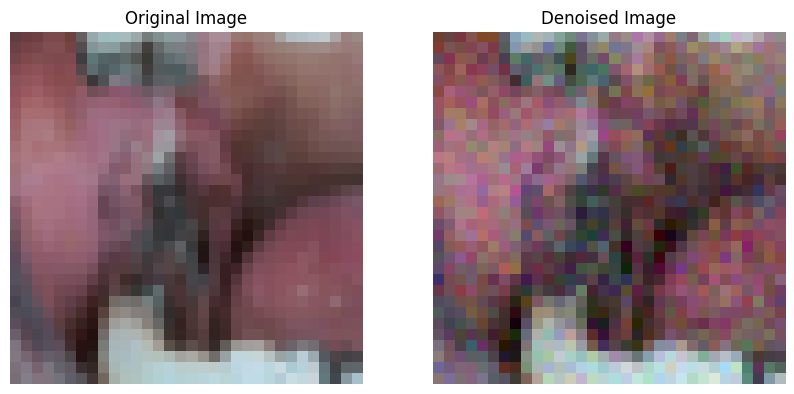

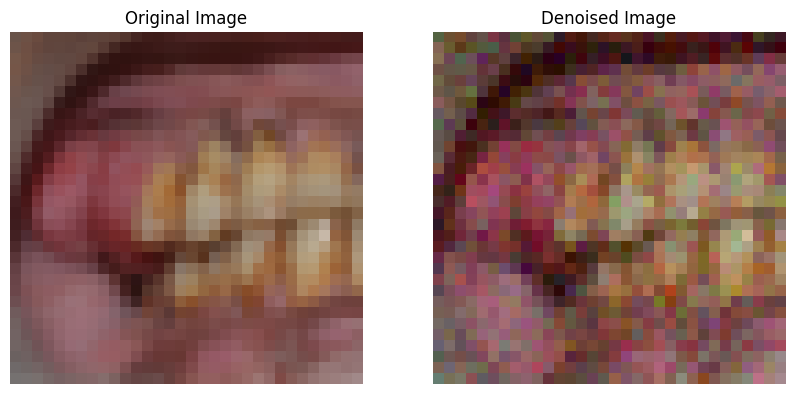

In [ ]:
# Apply the functions
noisy_matrices = represent_images_as_matrices(selected_images)
svd_results = apply_svd_to_images(noisy_matrices)

if svd_results is not None:
    truncated_images = truncate_small_singular_values(svd_results, threshold=50)

    denoised_images = reconstruct_denoised_image(svd_results)

    for i in range(3):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(selected_images[i].permute(1, 2, 0).numpy())
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_images[i])
        plt.title("Denoised Image")
        plt.axis('off')

        plt.show()
else:
    print("SVD results are empty. Check for errors in the previous steps.")

# Evaluation Metrics Calculation and Hyperparameter Analysis

In [ ]:
def calculate_metrics(original_images, denoised_images):
    psnr_values = []
    mse_values = []
    ssim_values = []

    for original, denoised in zip(original_images, denoised_images):

        original = (original.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        denoised = denoised.astype(np.uint8)

        psnr_value = psnr(original, denoised, data_range=255)
        psnr_values.append(psnr_value)

        mse_value = mse(original, denoised)
        mse_values.append(mse_value)

        ssim_value = ssim(original, denoised, data_range=255, win_size=3, channel_axis=-1)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average MSE: {avg_mse:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_mse, avg_ssim

average_psnr, average_mse, average_ssim = calculate_metrics(selected_images, denoised_images)

Average PSNR: 26.24 dB
Average MSE: 154.60
Average SSIM: 0.6783


In [ ]:
# Hyperparameter analysis
k_values = [10, 30, 50, 100]
metrics_results = {"k": [], "PSNR": [], "MSE": [], "SSIM": []}

for k in k_values:
    truncated_images = truncate_to_top_k_singular_values(svd_results, k)
    avg_psnr, avg_mse, avg_ssim = calculate_metrics(selected_images, truncated_images)

    metrics_results["k"].append(k)
    metrics_results["PSNR"].append(avg_psnr)
    metrics_results["MSE"].append(avg_mse)
    metrics_results["SSIM"].append(avg_ssim)

    print(f"k = {k} | Average PSNR: {avg_psnr:.2f} dB, Average MSE: {avg_mse:.2f}, Average SSIM: {avg_ssim:.4f}")

Average PSNR: 27.35 dB
Average MSE: 120.05
Average SSIM: 0.7306
k = 10 | Average PSNR: 27.35 dB, Average MSE: 120.05, Average SSIM: 0.7306
Average PSNR: 26.08 dB
Average MSE: 160.63
Average SSIM: 0.6706
k = 30 | Average PSNR: 26.08 dB, Average MSE: 160.63, Average SSIM: 0.6706
Average PSNR: 26.07 dB
Average MSE: 160.67
Average SSIM: 0.6703
k = 50 | Average PSNR: 26.07 dB, Average MSE: 160.67, Average SSIM: 0.6703
Average PSNR: 26.07 dB
Average MSE: 160.67
Average SSIM: 0.6703
k = 100 | Average PSNR: 26.07 dB, Average MSE: 160.67, Average SSIM: 0.6703


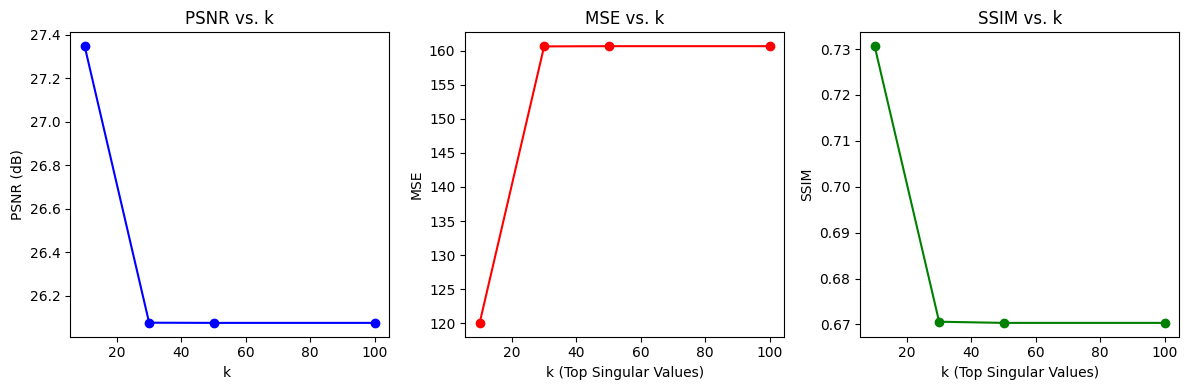

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(metrics_results["k"], metrics_results["PSNR"], marker='o', color='b')
plt.xlabel('k ')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. k')

plt.subplot(1, 3, 2)
plt.plot(metrics_results["k"], metrics_results["MSE"], marker='o', color='r')
plt.xlabel('k (Top Singular Values)')
plt.ylabel('MSE')
plt.title('MSE vs. k')

plt.subplot(1, 3, 3)
plt.plot(metrics_results["k"], metrics_results["SSIM"], marker='o', color='g')
plt.xlabel('k (Top Singular Values)')
plt.ylabel('SSIM')
plt.title('SSIM vs. k')

plt.tight_layout()
plt.show()